# Implementation of Residual Attention Network for Image Classification Paper

## Residual Attention Network Architecture
![Resnet Attention Network Architecture](images/resnet_attn_architecture.png)

## Implementation Details

#### Python Libraries
```
tensorflow               2.6.2
numpy                    1.19.5
matplotlib               3.5.0
python-magic             0.4.24
```

### Other Dependencies
- Kaggle API for acquiring the dataset (`pip install kaggle`)
- For reference of the API click [here](https://github.com/Kaggle/kaggle-api)

### Hardware Used

**GPU** : NVIDIA RTX 3060

#### Dataset Used
- [Weather Image Recognition](https://www.kaggle.com/jehanbhathena/weather-dataset) (Kaggle Dataset by Jehan Bhathena)
- **Image Classification Task with 11 Classes**

#### References
- [Residual Attention Network for Image Classification](https://arxiv.org/abs/1704.06904) (Original Paper by Fei Wang et.al.)
- [MixUp augmentation for image classification](https://keras.io/examples/vision/mixup/) (Keras Code Examples article by Sayak Paul)


#### Training Parameters:
- **Number of Training Epoch :** 29
- **Number of Batches:** 32


## Contents of this Jupyter Notebook


### Part 1 - Preliminaries
- Contains the initial helper codes

### Part 2 - Data Preprocessing/Augmentation
- Contains the code that performs preprocessing and data augmentation

### Part 3 - Building the Neural Network Architecture
- Contains the code that builds up the Residual Attention Network architecture from available Keras `Layers`

### Part 4 - Training the Model
- Contains the code that trains the Residual Attention model

### Part 5 - Results
- Contains the results of the training.

### Part 6 - Comments
- Commentary by me (Jummel Sasil)


In [5]:
%config Completer.use_jedi = False

# Part 1 - Preliminaries
- Contains the code the initial helper code

#### Import the Necessary Libraries

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob


In [7]:
from PIL import Image
from random import shuffle

import magic
import pathlib

#### I usually create this function make_dir so I can create directories easier

In [8]:
# Function for creating directories
def make_dir(target_dir):
    
    if not os.path.isdir(target_dir):
        print('Making Directory ', target_dir)
        os.mkdir(target_dir)
    else:
        print('Directory already exists')

#### Function for removing non-JPEG files

- The original **Weather Dataset** is predominantly JPEG files, but there are few other files such as PNG,GIF, and others. It would be simpler to remove the non-JPEG files since these files trigger decoding error when consumed by Keras' `keras.preprocessing.image_dataset_from_directory`
- Here, I used `python-magic` library to identify the file-format of raw image files.

In [9]:
def remove_non_jpg(target_dir):
    
    filepaths = glob.glob(target_dir + '/**/*', recursive=True)
    count = 0
    total = len(filepaths)
    
    for idx, fp in enumerate(filepaths, start=1):
        print(f'[{idx}/{total}] Processing files.', end='\r')
        if os.path.isfile(fp):
            if magic.from_file(fp).split(' ')[0] != 'JPEG':
                print('Removing file ', fp, end='\r')
                os.remove(fp)
                count += 1
    
    print('')
    print(f'Removed {count} non-jpg images')

In [10]:
!ls ~/.kaggle

kaggle.json


#### Downloading the Weather Dataset

- To download the **Weather Dataset**, it requires you to have Kaggle API installed in your Python Environment.
- To install simply type `pip install kaggle` in your command-line
- You also need to be registered in Kaggle and get the API token which will be saved on ~/.kaggle/kaggle.json
- To acquire the API token, simply go to `Accounts -> Create New API Token` which prompt a download for `kaggle.json`
- After that, simply `mv kaggle.json ~/.kaggle/kaggle.json` or just copy paste it inside `~/.kaggle`

**For more details you can visit**

- Kaggle API GitHub README.md [link](https://github.com/Kaggle/kaggle-api)
- Kaggle Website [link](https://www.kaggle.com/)


In [11]:
# You can replace it with directory of your choice
data_dir_root = '../dataset/dataset_v2/'

# This environment variable only stays during the runtime of this notebook
os.environ['RES_ATTN_DATASET'] = data_dir_root
os.environ['RES_ATTN_DATASET']

'../dataset/dataset_v2/'

In [12]:
make_dir(data_dir_root)

Directory already exists


In [9]:
!kaggle datasets download -d jehanbhathena/weather-dataset -p $RES_ATTN_DATASET --unzip

100%|████████████████████████████████████████| 587M/587M [02:25<00:00, 3.57MB/s]
100%|████████████████████████████████████████| 587M/587M [02:25<00:00, 4.23MB/s]


### Let's remove first the non-JPEGs

In [10]:
remove_non_jpg(data_dir_root)

[6874/6874] Processing files.
Removed 171 non-jpg images


In [13]:
data_dir_str = os.path.join(data_dir_root, 'dataset')
data_dir_str

'../dataset/dataset_v2/dataset'

In [14]:
data_dir = pathlib.Path(data_dir_str)
os.listdir(data_dir_str)

['dew',
 'lightning',
 'rainbow',
 'snow',
 'fogsmog',
 'rain',
 'hail',
 'frost',
 'glaze',
 'sandstorm',
 'rime']

## Now let's inspect the Images

#### For an image of dew category

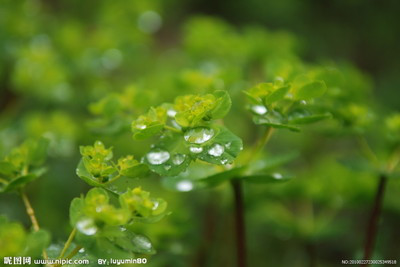

In [15]:
import PIL
sample_cat = list(data_dir.glob('dew/*'))
PIL.Image.open(str(sample_cat[5]))


#### For an image of frost category

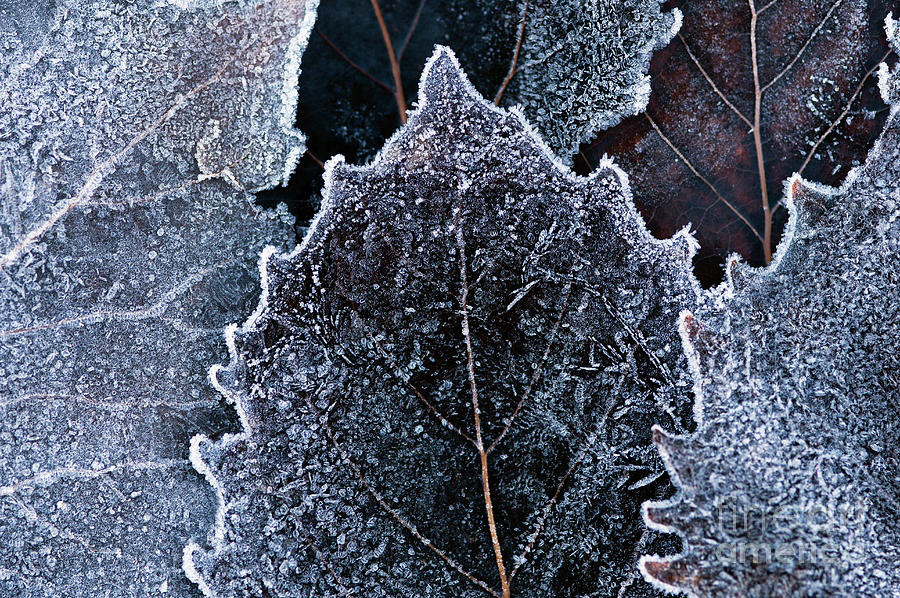

In [16]:
sample_cat = list(data_dir.glob('frost/*'))
PIL.Image.open(str(sample_cat[6]))

#### For an image of snow category

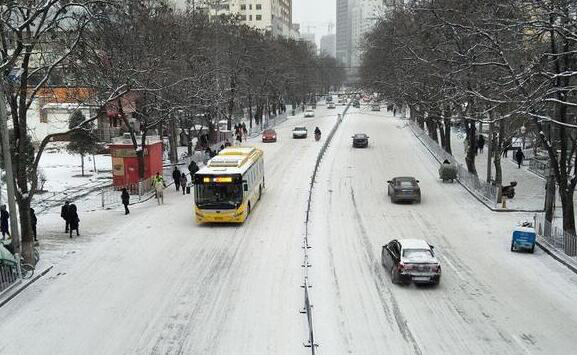

In [17]:
sample_cat = list(data_dir.glob('snow/*'))
PIL.Image.open(str(sample_cat[0]))

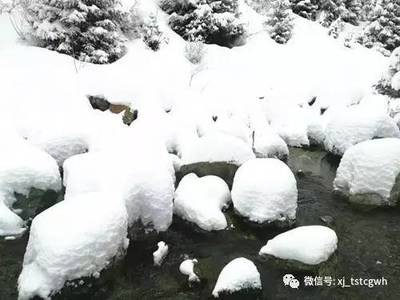

In [18]:
PIL.Image.open(str(sample_cat[2]))

### Wrapping up Part 1

Now that we verified that the images are ready, let's proceed to coding the **Preprocessing** and **Data Augmentation** part of this implementation

# Part 2 - Data Preprocessing/Augmentation
- Contains the code that performs preprocessing and data augmentation

### Using Keras API for handling images within a particular directory

- Here we'll use `keras.preprocessing.image_dataset_from_directory`
- There's also an alternative which is `keras.preprocessing.image.ImageDataGenerator.flow_from_directory` but it's difficult to directly convert it as `tf.data.Dataset` The API `keras.preprocessing.image_dataset_from_directory` is more appropriate since it's already a `tf.data.Dataset` subclass.
- And using `tf.data.Dataset` is the recommended practice.

In [19]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [20]:
import numpy as np

AUTO = tf.data.AUTOTUNE
batch_size = 32
img_height = 224
img_width = 224

SEED_ONE = np.random.randint(low=500, high=1000)


### Preparing tf.data.Dataset for MixUp Augmentation
- We will initialize our dataset first. We will initialize it in a way that we can perform **MixUp** data augmentation. In order to perform it we must be able to generate a pair of randomly sampled batch of inputs `image_one` and `image_two` where `image_one != image_two`
- I'll explain it later on why I've used **MixUp** Augmentation





In [28]:
tr_ds_init = keras.utils.image_dataset_from_directory(
  data_dir_str,
  validation_split=0.1,
  subset="training",
  seed=SEED_ONE,
  image_size=(img_height, img_width),
  batch_size=1, label_mode='categorical')


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_str,
  validation_split=0.1,
  subset="validation",
  seed=SEED_ONE,
  image_size=(img_height, img_width),
  batch_size=batch_size, label_mode='categorical')


tr_ds_one = (
    tr_ds_init.unbatch()                        # Unbatch the initial batch_size=1
    .shuffle(batch_size * 100)                  # Shuffle the data
    .batch(batch_size, drop_remainder=True)     # Set the batch_size=32 while dropping the remainder
)
    
tr_ds_two = (
    tr_ds_init.unbatch()
    .shuffle(batch_size * 100)
    .batch(batch_size, drop_remainder=True)
)


tr_ds = tf.data.Dataset.zip((tr_ds_one, tr_ds_two))

Found 6691 files belonging to 11 classes.
Using 6022 files for training.
Found 6691 files belonging to 11 classes.
Using 669 files for validation.


### Note on .batch(batch_size, drop_remainder=True)
- Initializing tf.data.Dataset `tr_ds_one` and `tr_ds_two` feels weird, but we simply want to eliminate the **excess** or the **remainder** last batch that are not equal to the designated `batch_size`.
- This is accomplished by setting `drop_remainder=True`

A Simple Illustration of excess batch_size looks like this

```

Let => [batch_size, height, width, channel]
where batch_size = 32

[32,224,224,3]     # batch_size = 32
[32,224,224,3]     # batch_size = 32
...
[32,224,224,3]     # batch_size = 32
[6,224,224,3]      # batch_size = 6       <- This is the remainder batch

```

The reason why we would want to remove the excess batch is because **MixUp** algorithm performs an **inner-product** on the pair of arbitrary matrices internally. If we don't discard the **remainder** batch, our implementation would end up multiplying matrices with unequal size. This is not allowed mathematically and with Tensorflow. 

**Therefore**, it's necessary for all batch to equal in size. 

In [23]:
# X,y = next(iter(tr_ds_one))

# print('Shape of tr_ds_one X = ', X.shape)
# print('Shape of tr_ds_one y = ', y.shape)

# X,y = next(iter(tr_ds_two))
# print('Shape of tr_ds_two X = ', X.shape)
# print('Shape of tr_ds_one y = ', y.shape)

#### Source:

Sayak Paul's Tutorial on MixUp Augmentation: https://keras.io/examples/vision/mixup/

### Implementing MixUp and combining them with different Data Augmentation

**MixUp** simply implement the following equation

$\text{MixUp Equation}$

$\tilde{x} = \lambda x_i + (1 - \lambda) x_j \quad \text{where } x_i, x_j \text{ are raw input vectors}$

$\tilde{y} = \lambda y_i + (1 - \lambda) y_j  \quad \text{where } y_i, y_j \text{ are one-hot label encoders}$

$\text{where } \lambda \text{ ~ } Beta(\alpha,\alpha)$


### Explaining the equations for MixUp
- We zipped the pair of `tf.data.Dataset` variables `tr_ds_one`, and `tr_ds_two`, this is equivalent with the input vectors $(x_i,y_i)$ and $(x_j,y_j)$ respectively
- Our custom layer below `MixingAugment` accepts an `alpha` parameter, and this `alpha` or $\alpha$ will serve as the parameter of the **Beta Distribution** to sample random numbers.
- Afterwards, we directly apply directly the equation within our Custom Keras Layer

### Note on Implementation:

- This is a refactored version of Sayak Paul's Keras Tutorial https://keras.io/examples/vision/mixup/

In [29]:

class MixingAugment(keras.layers.Layer):
    
    def __init__(self, alpha=0.2, *args, **kwargs):
        super(MixingAugment,self).__init__(*args, **kwargs)
        
        self.post_mix = keras.Sequential([
              keras.layers.RandomFlip("horizontal"),
              keras.layers.RandomRotation(0.2),
              keras.layers.Rescaling(1./255)
        ])
        
        self.alpha = 0.2
        
    def sample_beta_distribution(self, size, concentration_0=0.2, concentration_1=0.2):
        gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
        gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
        return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

    
    def mix_up(self, ds_one, ds_two):
        # Unpack two datasets
        images_one, labels_one = ds_one
        images_two, labels_two = ds_two
        
        batch_size = tf.shape(images_one)[0]
        
        # Sample lambda and reshape it to do the mixup
        l = self.sample_beta_distribution(batch_size, self.alpha, self.alpha)
        x_l = tf.reshape(l, (batch_size, 1, 1, 1))
        y_l = tf.reshape(l, (batch_size, 1))

        # Perform mixup on both images and labels by combining a pair of images/labels
        # (one from each dataset) into one image/label
        images = images_one * x_l + images_two * (1 - x_l)
        labels = labels_one * y_l + labels_two * (1 - y_l)
        return (images, labels)
    

    def call(self, data_one, data_two):
        
        x, y = self.mix_up(data_one, data_two)
        x = self.post_mix(x)
        return x,y
    
    
val_augmentation = tf.keras.Sequential([
  keras.layers.Rescaling(1./255)
])
        

### Mapping Directly MixingAugment() to our training dataset

In [30]:

mix_aug = MixingAugment(alpha=0.4)

tr_ds = tr_ds.map(
    lambda data_one, data_two : mix_aug(data_one, data_two), num_parallel_calls=AUTO
)

val_ds = val_ds.map(
    lambda X,y : (val_augmentation(X),y), num_parallel_calls=AUTO
)

### Plotting the MixUp augmented images
- You can play with the parameter alpha in MixingAugment. According to the the paper [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412), the range of alpha $\alpha$ can range from 0 to $\infty$
- You'll notice that two images are blended to one image.


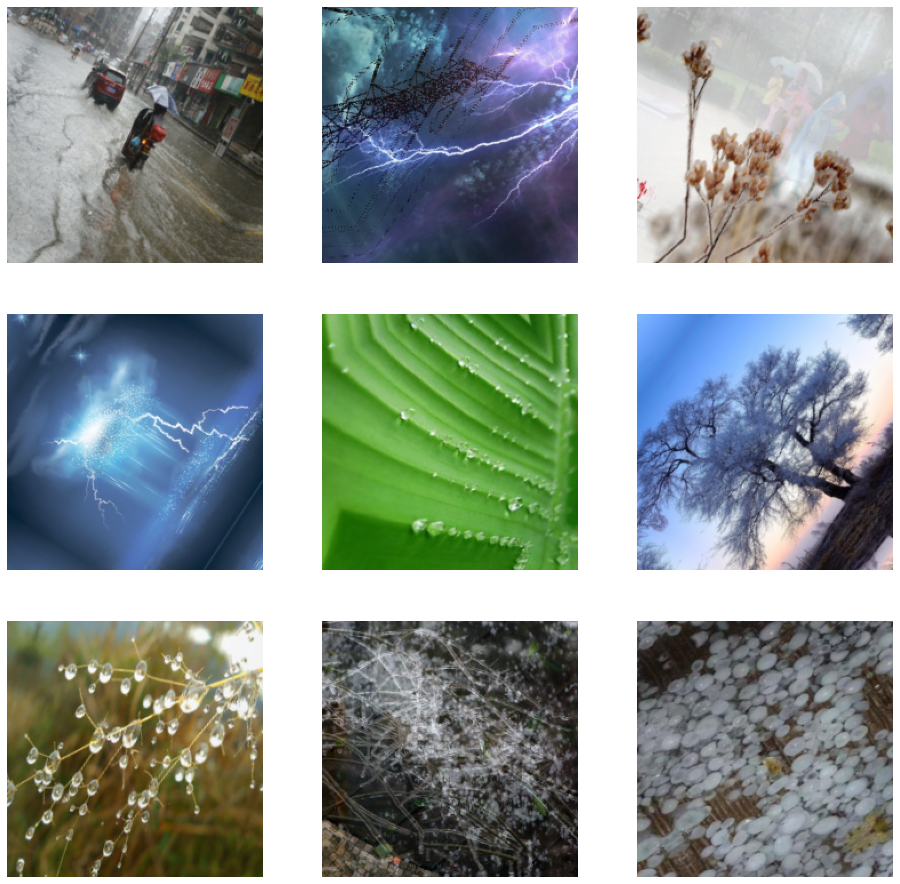

In [31]:
sample_images, sample_labels = next(iter(tr_ds))
plt.figure(figsize=(16, 16))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

### Inspecting the labels

Instead of fixed one-hot coded labels like `[0,1,0,0]` this will go like `[0, 0.9, 0.1, 0.0]`

Let's print the label to see what it actually looks like

In [43]:
sample_labels.numpy()[0:2,:]


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.96444625, 0.        , 0.        , 0.03555376,
        0.        ],
       [0.02926833, 0.        , 0.        , 0.        , 0.        ,
        0.9707317 , 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32)

### Why use MixUp Augmentation for this Dataset

- Though the original paper doesn't mention using this particular Image Augmentation, my initial experiments doesn't yield to a decent results with **Weather Dataset**. Without this, the validation losses are unstable and barely reaches **40%-50%** validation accuracy.
- My suspicion is that simple augmentation such as Random Crop, Random Rotation, and Random Flip doesn't capture the regularities that weather conditions exhibits. But **MixUp** enables me to reach 60%+ on without much of fine tuning.


#### Wrapping up Part 2
- Now let's move on to Part 3 which is building the actual Neural Network Architecture

# Part 3 - Building the Neural Network Architecture
- Contains the code that builds up the Residual Attention Network architecture from available Keras `keras.layers.Layer` and Keras base model `keras.models.Model`

## Overall Strategy in Building the whole Neural Network Architecture

- Since the whole model itself has recurring components, it will be appropriate to encapsulate them with different subclasses of `keras.layers.Layer` and `keras.models.Model`
- The largest subcomponent of the whole model is the **Attention Module**. Hence, we will encapsulate it inside a `keras.models.Model` subclass named `ResidualAttentionModule`. Since the actual model itself cascades the **Attention Modules**, we will stack three `ResidualAttentionModule` in a `keras.Sequential` object together with other components.
- To understand this further, let's take a big picture look on the architecture again. But this time, we will label the appropriate class names with each components.


## Architecture with Class Labels
![Implementation Diagram](images/implementation_diagram.png)

### Creating the Layer for Initial Convolutional Layer

Basically, it's just your conventional subset of CNN layers which are the following

- `keras.layers.Conv2D` w/ zero-padding (Convolutional Layer)
- `keras.layers.BatchNorm` (Batch Normalization)
- `keras.layers.MaxPool2D` w/ zero-padding (Max Pooling Layer)


Note: 

You might wonder, why bother implementing these three layers with a custom `keras.layers.Layer` if I can simply stack them in a keras.Sequential directly like 

```
initial_conv = keras.Sequential([
    keras.layers.Conv2D(...),
    keras.layers.BatchNorm(),
    keras.layers.MaxPool2D()
])
```

Well, my reasoning for this is simply because the model is fairly large. I want easily debug each code in terms of class modules (Easier to trace bugs). Basically, its just a practice of a more **defensive** approach in coding Neural Networks, which Andrej Karpathy [suggested](http://karpathy.github.io/2019/04/25/recipe/).

In [25]:
class InitialConv(keras.layers.Layer):
    
    def __init__(self, 
                 filters : int, 
                 kernel_size : int, 
                 strides : int,
                 pool_size : int,
                 data_format='channels_last',
                 activation='relu',
                 conv_pad_size=3,
                 pool_pad_size=1,
                 *args, **kwargs):
        
        super(InitialConv, self).__init__(*args, **kwargs)
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides

        self.pool_size = pool_size
        self.data_format = data_format
        self.activation = keras.activations.get(activation)
        
        self.conv_pad_size = conv_pad_size
        self.pool_pad_size = pool_pad_size
        
        
    def build(self, input_shape):
        
        conv_pad_shape = (self.conv_pad_size, self.conv_pad_size)
        
        self.zpad_01 = keras.layers.ZeroPadding2D(
            padding=conv_pad_shape,
            data_format=self.data_format,
            input_shape=input_shape)
        
        self.conv = keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format
        )
        
        self.bnorm = keras.layers.BatchNormalization()
        pool_pad_shape = (self.pool_pad_size, self.pool_pad_size)
        
        self.zpad_02 = keras.layers.ZeroPadding2D(
            padding=pool_pad_shape,
            data_format=self.data_format
        )
        
        self.pool = keras.layers.MaxPool2D(
            pool_size=self.pool_size,
            strides=self.strides, 
            padding='valid'
        )
        
        
    def call(self, x):
        
        x = self.zpad_01(x)
        x = self.conv(x)
        x = self.bnorm(x)
        x = self.activation(x)
        x = self.zpad_02(x)
        x = self.pool(x)
        
        return x
            

### Batch Normalized Convolutional Layer

This is a recurring sequence of layers within the **Residual Block** (or Residual Unit) itself. So basically this is just a series of layers within a custom layer that does the following in order


- `keras.layers.BatchNorm2D` (**Batch Normalization**)
- `keras.layers.Activation` (**ReLU**)
- `keras.layers.ZeroPad` (**Zero Padding**)
- `keras.layers.Conv2D` (**Convolution Layer**)

In [26]:
class BatchNormConv2D(keras.layers.Layer):
    
    def __init__(self, 
                 filters,
                 kernel_size=1,
                 strides=1,
                 padding_size=0,
                 activation='relu',
                 data_format='channels_last',
                 *args, **kwargs):
        
        super(BatchNormConv2D, self).__init__(*args, **kwargs)
        self.activation = keras.activations.get(activation)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.data_format=data_format
        
        self.padding_size = padding_size
                            

    def build(self, input_shape):
        
        self.bnorm = keras.layers.BatchNormalization(
            input_shape=input_shape)
        

        padding_shape = (self.padding_size, self.padding_size)
        
        self.zero_pad = keras.layers.ZeroPadding2D(
            padding=padding_shape,
            data_format=self.data_format
        )
        
        self.conv = keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format
        )
        
         
    def call(self, x):
        
        x = self.bnorm(x)
        x = self.activation(x)
        x = self.zero_pad(x)
        x = self.conv(x)
        return x




### Implementing Residual Block
- This paper uses the implementation of Residual Block from the [paper](https://arxiv.org/abs/1603.05027) **Identity Mappings in Deep Residual Networks** which uses a version where Batch Normalization goes first.

#### Residual Block from Identity Mappings in Deep Residual Networks
![Residual Block](images/residual_block.png)

Basically, the **Residual Block** simply does the following:

```
# Diagram of Residual Block

================================================================================
input -> BatchNormConv2D -> BatchNormConv2D -> BatchNormConv2D -> + ---> Output   
  |                                                               |
  |                                                               |
  *------------> skip_connection (keras.layers.Conv2D) -----------*
================================================================================
```

- An the original **input** passes 3 layers of custom class `BatchNormConv2D`
- The original **input** also passes to the **skip connection** w/ of a Convolution Layer 
- Add the output of **skip-connection** and the result of 3 layers of `BatchNormConv2D`

In [27]:
class ResidualBlock(keras.layers.Layer):
    
    def __init__(self, 
                 filters, 
                 strides=1, 
                 data_format='channels_last',
                 *args, **kwargs):
        
        super(ResidualBlock, self).__init__(*args, **kwargs)
        
        self.filters = filters
        
        self.mid_kernel_size = 3
        self.mid_pad_size = 1
        
        self.strides = strides
        self.data_format= data_format
        
    
    def create_projection(self, input_shape):
        return keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=1,
            strides=self.strides,
            data_format=self.data_format
        )
    
        
    def build(self, input_shape):
        
        f1 = self.filters // 4
        f2 = self.filters // 4
        f3 = self.filters 
        
        self.projection = self.create_projection(input_shape=input_shape)
        
        self.bn_conv1 = BatchNormConv2D(filters=f1,
                                        data_format=self.data_format,
                                        input_shape=input_shape)
        
        self.bn_conv2 = BatchNormConv2D(filters=f2, 
                                        kernel_size=self.mid_kernel_size, 
                                        padding_size=self.mid_pad_size,
                                        strides=self.strides,
                                        data_format=self.data_format)
        
        self.bn_conv3 = BatchNormConv2D(filters=f3, 
                                        data_format=self.data_format)
        
        
    def call(self, x):
        
        skip = self.projection(x)
        
        x = self.bn_conv1(x)
        x = self.bn_conv2(x)
        x = self.bn_conv3(x)
        
        return x + skip      
        
            

In [28]:
class ResidualBlocks(keras.models.Model):
    
    def __init__(self, 
                 filters,
                 data_format='channels_last',
                 depth=1, *args, **kwargs):
        
        super(ResidualBlocks, self).__init__(*args, **kwargs)
        
        assert depth > 0, 'trunk_depth must be greater than zero.'
        
        self.data_format = data_format
        self.depth = depth
        self.filters = filters
        
        blocks = self.depth * [
            ResidualBlock(filters=self.filters, 
                          data_format=self.data_format)
        ]
        
        self.main_trunk = keras.Sequential(blocks)


    def call(self, x):
        return self.main_trunk(x)
        
        

In [29]:
class SoftMaskBranch_STG_01(keras.models.Model):
    
    def __init__(self, filters, 
                 num_segments=1,
                 data_format='channels_last', 
                 *args, **kwargs):
        
        super(SoftMaskBranch_STG_01, self).__init__(*args, **kwargs)
                
        self.num_segments = num_segments
        self.data_format = data_format
        self.filters = filters
        
        self.down_sampler = keras.layers.MaxPool2D((3,3), 2, data_format=self.data_format)
        
        self.up_sampler_01 = keras.layers.Resizing(13,13)
        self.up_sampler_02 = keras.layers.Resizing(27,27)
        self.up_sampler_03 = keras.layers.Resizing(56,56)        
        
        self.rb_01 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_02 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_03 = ResidualBlocks(filters, depth=2*num_segments, data_format=self.data_format)
        self.rb_04 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_05 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        
        self.conv_06 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='relu', 
                                           data_format=self.data_format)
        
        self.conv_07 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='sigmoid', 
                                           data_format=self.data_format)
        
        self.rb_skip_01 = ResidualBlock(filters, data_format=self.data_format)
        self.rb_skip_02 = ResidualBlock(filters, data_format=self.data_format)
        
        
    def call(self, x):
        
        
        # Input (56x56)
        x = self.down_sampler(x)        # downsampled size = (27x27)
        x = self.rb_01(x)
        
        skip_01 = self.rb_skip_01(x)    
        
        print()
        x = self.down_sampler(x)        # downsampled size = (13x13)
        x = self.rb_02(x)
        skip_02 = self.rb_skip_02(x)    
        
        
        x = self.down_sampler(x)        # downsampled size = (6x6)
        x = self.rb_03(x)
                
        
        x = self.up_sampler_01(x)       # upsampled size = (13x13)
        x += skip_02
        x = self.rb_04(x)
        
        x = self.up_sampler_02(x)       # upsampled size = (27x27)
        x += skip_01
        x = self.rb_05(x)
        
        x = self.up_sampler_03(x)       # upsampled size = (27x27)
        
        x = self.conv_06(x)
        x = self.conv_07(x)
        
        return x
        
        
        

In [30]:
class SoftMaskBranch_STG_02(keras.models.Model):
    
    def __init__(self, filters, 
                 num_segments=1,
                 data_format='channels_last', 
                 *args, **kwargs):
        
        super(SoftMaskBranch_STG_02, self).__init__(*args, **kwargs)
                
        self.num_segments = num_segments
        self.data_format = data_format
        self.filters = filters
        
        self.down_sampler = keras.layers.MaxPool2D((3,3), 2, data_format=self.data_format)
        
        self.up_sampler_01 = keras.layers.Resizing(13,13)
        self.up_sampler_02 = keras.layers.Resizing(28,28)
        
        self.rb_01 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_02 = ResidualBlocks(filters, depth=2*num_segments, data_format=self.data_format)
        self.rb_03 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        
        self.conv_05 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='relu',
                                           data_format=self.data_format)
        
        self.conv_06 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='sigmoid',
                                           data_format=self.data_format)
        
        self.rb_skip_01 = ResidualBlock(filters, data_format=self.data_format)
        
        
    def call(self, x):
        
        x = self.down_sampler(x)        # downsampled size = (13x13)
        x = self.rb_01(x)
        skip_01 = self.rb_skip_01(x)    
        
        x = self.down_sampler(x)        # downsampled size = (13x13)
        x = self.rb_02(x)
        
        x = self.up_sampler_01(x)       # upsampled size = (13x13)
        x += skip_01
        x = self.rb_03(x)
        
        x = self.up_sampler_02(x)       # upsampled size = (28x28)
        
        x = self.conv_05(x)
        x = self.conv_06(x)
        
        return x
        
        
        

In [31]:
class SoftMaskBranch_STG_03(keras.models.Model):
    
    def __init__(self, filters, 
                 num_segments=1,
                 data_format='channels_last', 
                 *args, **kwargs):
        
        super(SoftMaskBranch_STG_03, self).__init__(*args, **kwargs)
                
        self.num_segments = num_segments
        self.data_format = data_format
        self.filters = filters
        
        self.down_sampler = keras.layers.MaxPool2D((3,3), 2)
        
        self.up_sampler_01 = keras.layers.Resizing(14,14)
        
        self.rb_01 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_02 = ResidualBlocks(filters, depth=2*num_segments, data_format=self.data_format)
        self.rb_03 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        
        self.conv_05 = keras.layers.Conv2D(filters, kernel_size=1, 
                                           activation='relu', 
                                           data_format=self.data_format)
        
        self.conv_06 = keras.layers.Conv2D(filters, kernel_size=1, 
                                           activation='sigmoid',
                                           data_format=self.data_format)
        

        
    def call(self, x):
                
        x = self.down_sampler(x)        # downsampled size = (6x6)

        x = self.rb_01(x)
        x = self.rb_02(x)
        x = self.rb_03(x)

        
        x = self.up_sampler_01(x)       # upsampled size = (13x13)

        x = self.conv_05(x)
        x = self.conv_06(x)

        
        return x

In [32]:
class ResidualAttentionModule(keras.models.Model):
    
    def __init__(self, filters, stage,
                       pre_post_depth=1, 
                       trunk_depth=2,
                       soft_mask_segments=1,
                       *args, **kwargs):
        
        super(ResidualAttentionModule, self).__init__(*args, **kwargs)
        
        
        assert 0 < stage <= 3, 'Stage must be either 1,2,3'
        
        self.filters = filters
        self.stage = stage
        self.pre_post_depth = pre_post_depth
        self.trunk_depth = trunk_depth
        self.soft_mask_segments = soft_mask_segments
        
        
        self.pre_blocks = ResidualBlocks(filters=self.filters,
                                          depth=self.pre_post_depth)
        
        self.trunk_branch = ResidualBlocks(filters=self.filters, 
                                           depth=self.trunk_depth)
        
        self.post_blocks = ResidualBlocks(filters=self.filters,
                                          depth=self.pre_post_depth)
        
        
        if stage == 1:
            self.soft_mask_branch = SoftMaskBranch_STG_01(filters=self.filters,
                                                          num_segments=self.soft_mask_segments)
            
        elif stage == 2:
            self.soft_mask_branch = SoftMaskBranch_STG_02(filters=self.filters,
                                                          num_segments=self.soft_mask_segments)
            
        elif stage == 3:
            self.soft_mask_branch = SoftMaskBranch_STG_03(filters=self.filters,
                                                          num_segments=self.soft_mask_segments)
            
            
    def call(self, x):
        
        x = self.pre_blocks(x)
 
        x_trunk = self.trunk_branch(x)
        x_mask = self.soft_mask_branch(x)
        x_masked = tf.math.multiply(x_trunk, x_mask)
        x = tf.math.add(x_trunk, x_masked)
        x = self.post_blocks(x)
        
        return x
        
        


In [33]:
model_root = '../model'
model_dir = '../model/residual_attention_v9'

make_dir(model_root)
make_dir(model_dir)

Directory already exists
Directory already exists


In [34]:

N_CLASSES = 11

model = keras.Sequential([

    InitialConv(filters=32, 
                kernel_size=7,
                strides=2, 
                pool_size=3, 
                input_shape=[224,224,3]),
    
    # STAGE 1 Attention Module
    ResidualAttentionModule(filters=128, stage=1),
    
    # STAGE 2 Attention Module
    ResidualBlock(filters=256, strides=2),
    ResidualAttentionModule(filters=256, stage=2),
    
    
    ResidualBlock(filters=512, strides=2),
    ResidualAttentionModule(filters=512, stage=3),
    
    
    ResidualBlock(filters=1028, strides=1),
    ResidualBlock(filters=1028, strides=1),
    ResidualBlock(filters=1028, strides=2),
    
    
    keras.layers.AveragePooling2D((7,7), strides=1),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(100, 'relu'),

    keras.layers.Dense(N_CLASSES, 'softmax')
])




In [35]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


model_path = os.path.join(model_dir, 'model.h5')
model_cb = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True)
es_cb = EarlyStopping(monitor='val_accuracy', patience=10)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
              loss='categorical_crossentropy', metrics='accuracy')

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
initial_conv (InitialConv)   (None, 56, 56, 32)        4864      
_________________________________________________________________
residual_attention_module (R (None, 56, 56, 128)       366080    
_________________________________________________________________
residual_block_10 (ResidualB (None, 28, 28, 256)       95872     
_________________________________________________________________
residual_attention_module_1  (None, 28, 28, 256)       1092992   
_________________________________________________________________
residual_block_18 (ResidualB (None, 14, 14, 512)       380160    
_________________________________________________________________
residual_attention_module_2  (None, 14, 14, 512)       3795456   
_________________________________________________________________
residual_block_25 (ResidualB (None, 14, 14, 1028)    

In [ ]:
num_epochs = 100
history = model.fit(tr_ds, validation_data=val_ds, epochs=num_epochs, callbacks=[model_cb, es_cb])

Epoch 1/100




2021-12-14 00:37:08.340262: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-12-14 00:37:09.125118: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-14 00:37:09.125604: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-14 00:37:09.125627: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-12-14 00:37:09.126068: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-14 00:37:09.126121: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-14 00:37:11.153494: W tensorflow/core/common_runtime/bf

    188/Unknown - 64s 204ms/step - loss: 1.9493 - accuracy: 0.4091


2021-12-14 00:37:57.930400: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


188/188 [==============================] - 68s 229ms/step - loss: 1.9493 - accuracy: 0.4091 - val_loss: 2.8014 - val_accuracy: 0.1839


2021-12-14 00:37:58.172553: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Epoch 2/100
188/188 [==============================] - 50s 213ms/step - loss: 1.5931 - accuracy: 0.4970 - val_loss: 2.7171 - val_accuracy: 0.2631
Epoch 3/100
188/188 [==============================] - 51s 213ms/step - loss: 1.4803 - accuracy: 0.5387 - val_loss: 1.1941 - val_accuracy: 0.5830
Epoch 4/100
188/188 [==============================] - 51s 213ms/step - loss: 1.4496 - accuracy: 0.5542 - val_loss: 1.3562 - val_accuracy: 0.5157
Epoch 5/100
188/188 [==============================] - 51s 214ms/step - loss: 1.3913 - accuracy: 0.5819 - val_loss: 1.2575 - val_accuracy: 0.5665
Epoch 6/100
188/188 [==============================] - 51s 214ms/step - loss: 1.3455 - accuracy: 0.5951 - val_loss: 1.2036 - val_accuracy: 0.5964
Epoch 7/100
188/188 [==============================] - 51s 215ms/step - loss: 1.2999 - accuracy: 0.6107 - val_loss: 1.2992 - val_accuracy: 0.5531
Epoch 8/100
188/188 [==============================] - 51s 215ms/step - loss: 1.3044 - accuracy: 0.6124 - val_loss: 2.3385 -

In [57]:
hist_data = history.history.copy()

In [62]:
import json

def save_json(hist_data, path):
    
    with open(path,'w') as f:
        f.write(json.dumps(hist_data, indent=4))
        
save_json(hist_data, 'history_data.json')

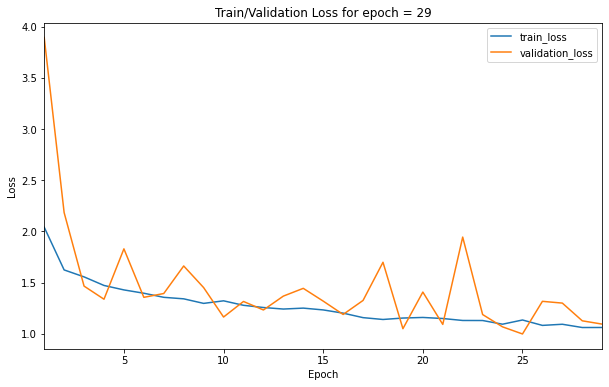

In [89]:
total_epoch = len(hist_data['loss'])
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1,30), hist_data['loss'], label='train_loss')
plt.plot(np.arange(1,30), hist_data['val_loss'], label='validation_loss')
plt.legend()
plt.title(f'Train/Validation Loss for epoch = {total_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim([1,29])
plt.show()

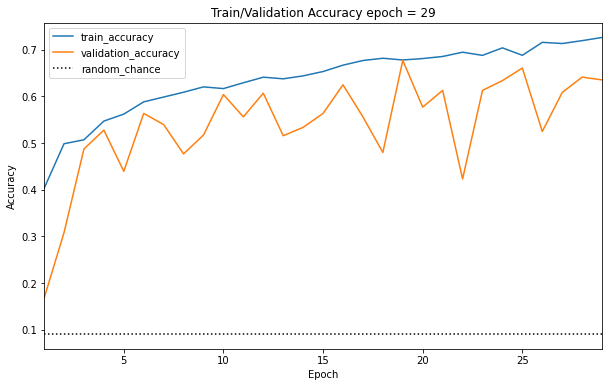

In [91]:
random_chance = 1.0 / 11.0   # Prediction by random chance


plt.figure(figsize=(10, 6))
plt.plot(np.arange(1,30), hist_data['accuracy'], label='train_accuracy')
plt.plot(np.arange(1,30), hist_data['val_accuracy'], label='validation_accuracy')
plt.axhline(y=random_chance, color='k', label='random_chance', linestyle='dotted')
plt.legend()
plt.title(f'Train/Validation Accuracy epoch = {total_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([1,29])
plt.show()

In [72]:
print('Best Validation Loss: ',np.min(hist_data['val_loss']))
print('Best Validation Accuracy: ',np.max(hist_data['val_accuracy']))

Best Validation Loss:  0.9973596930503845
Best Validation Accuracy:  0.6771300435066223


In [56]:
make_dir('../dataset/resized_dataset')

![Residual Unit](images/residual_unit.png)

In [12]:
from resnet_50 import building_block, block_layer

![Architecture](images/resnet_attn_architecture.png)

![Parameter Reference](images/layer_parameter_table.png)